In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import deepcell
# Changed from before due to new placement of Track, concat_tracks
from deepcell_tracking.utils import load_trks
from deepcell.data.tracking import Track, concat_tracks
##############
from sklearn.model_selection import train_test_split
from deepcell.utils.data_utils import reshape_movie
from deepcell.utils.transform_utils import erode_edges
from deepcell.data import split_dataset
from deepcell_toolbox.processing import normalize, histogram_normalization

import spektral

2.8.0


In [2]:
import json
def load_img_dict(file):
    f = open(file)
    d = json.load(f)
    d = {int(k1): {int(k2): {int(k3): v for k3, v in d[k1][k2].items()} for k2, d[k1][k2] in d[k1].items()} for k1, d[k1] in d.items()}
    return d
def load_img_idx_dict(file):
    f = open(file)
    d = json.load(f)
    d = {int(k): v for k, v in d.items()}
    return d

In [3]:
train_good_imgs = load_img_dict('../dataset_pruning/train_appearances_dict.json')
train_blank_imgs = load_img_dict('../dataset_pruning/train_blank_dict.json')
train_border_imgs = load_img_dict('../dataset_pruning/train_border_dict.json')
val_good_imgs = load_img_dict('../dataset_pruning/val_appearances_dict.json')
val_blank_imgs = load_img_dict('../dataset_pruning/val_blank_dict.json')
val_border_imgs = load_img_dict('../dataset_pruning/val_border_dict.json')

In [4]:
import csv
import os

from tensorflow.data import Dataset
from tensorflow.io import serialize_tensor
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import is_sparse

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        # BytesList won't unpack a string from an EagerTensor.
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_array(array):
    array = tf.io.serialize_tensor(array)
    return array

def create_tracking_example(image):
    # At some point might need to consider having reconstruction image
    #define the dictionary -- the structure -- of our single example
    data = {
        'height' : _int64_feature(image.shape[0]),
        'width' : _int64_feature(image.shape[1]),
        'depth' : _int64_feature(image.shape[2]),
        'raw_image' : _bytes_feature(serialize_array(image))
    }
    #create an Example, wrapping the single features
    out = tf.train.Example(features=tf.train.Features(feature=data))
    
    return out

In [53]:
from skimage.exposure import rescale_intensity

def norm(X, size):
    X_norm = histogram_normalization(X, kernel_size=size)
    
    X_rescaled = np.zeros(X_norm.shape)
    for img_idx in range(X.shape[0]):
        x = X[img_idx]
        x = rescale_intensity(x, out_range=(0,1))
        X_rescaled[img_idx] = x
            
    return X_rescaled

In [35]:
def write_tracking_dataset_to_tfr(track, filename, good_imgs):
    app_type = track.appearances.dtype
    app = norm(track.appearances, 32).astype(app_type)
    filename = "/data/tf_records/" + filename + ".tfrecords"
    writer = tf.io.TFRecordWriter(filename) #create a writer that'll store our data to disk
    count = 0

    for b in range(app.shape[0]):
        for f in range(app.shape[1]):
            for c in range(app.shape[2]):
                if good_imgs[b][c][f] != -1:
                    current_image = app[b, f, c]

                    out = create_tracking_example(current_image)

                    if out is not None:
                        writer.write(out.SerializeToString())
                        count += 1

    writer.close()
    print(f'Wrote {count} elements to TFRecord')
    return count

In [7]:
train_trks = load_trks(os.path.join('/training/tracking-nuclear', 'train.trks'))
val_trks = load_trks(os.path.join('/training/tracking-nuclear', 'val.trks'))

In [10]:
with tf.device('/cpu:0'):
    val_tracks = Track(tracked_data=val_trks,
                   appearance_dim=32,
                   distance_threshold=64,
                   crop_mode='resize')

    write_tracking_dataset_to_tfr(val_tracks, filename='val_small', good_imgs=val_good_imgs)

2022-08-12 16:33:43.246594: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-12 16:33:44.255944: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10415 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1
100%|███████████████████████████████████████████| 27/27 [01:52<00:00,  4.17s/it]
2022-08-12 16:38:03.901926: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1060745520 exceeds 10% of free system memory.


Wrote 89436 elements to TFRecord


In [36]:
with tf.device('/cpu:0'):
    write_tracking_dataset_to_tfr(val_tracks, filename='val_small', good_imgs=val_good_imgs)

Wrote 89436 elements to TFRecord


In [37]:
val_appearances = val_tracks.appearances
val_appearances.shape

(27, 71, 277, 32, 32, 1)

In [38]:
val_appearances_normed = norm(val_tracks.appearances, 32)
val_appearances.shape

KeyboardInterrupt: 

In [30]:
val_appearances_normed.dtype

dtype('float64')

In [39]:
val_appearances.dtype

dtype('float32')

In [33]:
t = val_appearances.dtype
val_appearances_normed = val_appearances_normed.astype(t)

In [34]:
val_appearances_normed.dtype

dtype('float32')

In [54]:
with tf.device('/cpu:0'):
    train_tracks = Track(tracked_data=train_trks,
                   appearance_dim=32,
                   distance_threshold=64,
                   crop_mode='resize')

    write_tracking_dataset_to_tfr(train_tracks, filename='train_small', good_imgs=train_good_imgs)

100%|███████████████████████████████████████████| 91/91 [16:23<00:00, 10.80s/it]
2022-08-12 20:36:16.935917: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5634910840 exceeds 10% of free system memory.


Wrote 383800 elements to TFRecord


In [18]:
val_tracks.appearances.shape

(27, 71, 277, 32, 32, 1)

In [19]:
type(val_tracks.appearances[0][0][0][0][0][0])

numpy.float32

In [55]:
def parse_tfr_element(element):
    #use the same structure as above; it's kinda an outline of the structure we now want to create
    data = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width':tf.io.FixedLenFeature([], tf.int64),
        'depth':tf.io.FixedLenFeature([], tf.int64),
        'raw_image' : tf.io.FixedLenFeature([], tf.string)
    }


    content = tf.io.parse_single_example(element, data)

    height = content['height']
    width = content['width']
    depth = content['depth']
    raw_image = content['raw_image']
    

    #get our 'feature'-- our image -- and reshape it appropriately
    feature = tf.io.parse_tensor(raw_image, out_type=tf.float32)
    feature = tf.reshape(feature, shape=[height,width,depth])
    return (feature, feature)

In [56]:
def get_dataset(filename, batch_size=1, buffer_size=256,
                    seed=None):
    #create the dataset
    dataset = tf.data.TFRecordDataset(filename)

    #pass every single feature through our mapping function
    dataset = dataset.map(
      parse_tfr_element
    )
    
    dataset = dataset.shuffle(buffer_size, seed=seed)

    dataset = dataset.repeat().batch(batch_size)
    
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [57]:
val_dataset = get_dataset("/data/tf_records/val_small.tfrecords", batch_size=100)

In [58]:
train_dataset = get_dataset("/data/tf_records/train_small.tfrecords", batch_size=100)

In [44]:
for sample in val_dataset.take(1):
    print(type(sample))
    print(len(sample))
    print(sample[0].shape)
    print(sample[1].shape)

<class 'tuple'>
2
(100, 32, 32, 1)
(100, 32, 32, 1)


In [28]:
for sample in train_dataset.take(1):
    print(type(sample))
    print(len(sample))
    print(sample[0].shape)
    print(sample[1].shape)

<class 'tuple'>
2
(100, 32, 32, 1)
(100, 32, 32, 1)


In [48]:
import matplotlib.pyplot as plt
for sample in val_dataset.take(895):
    if np.isnan(sample[0]).any():
        print('NaN')
print('Finished searching')

Finished searching


In [ ]:
# So the data does not have NaNs

In [40]:
a = np.array([1,2,3,4,6])
np.any((a < 1)|(a > 5 ))

True

In [51]:
for sample in val_dataset.take(895):
    if np.any((sample[0] < 0)|(sample[0] > 1 )):
        print('Not normalized?')

In [52]:
import sys
np.set_printoptions(threshold=sys.maxsize)
for sample in val_dataset.take(1):
    print(sample[0][0])

tf.Tensor(
[[[0.02128082]
  [0.02136328]
  [0.02113521]
  [0.02175012]
  [0.02345452]
  [0.02413171]
  [0.02667032]
  [0.02803788]
  [0.0278291 ]
  [0.02941069]
  [0.03205544]
  [0.03212299]
  [0.03208264]
  [0.03491598]
  [0.03501774]
  [0.03543792]
  [0.03281334]
  [0.02994139]
  [0.02701506]
  [0.02360452]
  [0.02434663]
  [0.0236782 ]
  [0.02177293]
  [0.0212124 ]
  [0.02022818]
  [0.02032029]
  [0.02067555]
  [0.02178082]
  [0.02123258]
  [0.02170275]
  [0.01924397]
  [0.02022643]]

 [[0.02189701]
  [0.02197278]
  [0.02145459]
  [0.02202937]
  [0.02399462]
  [0.02638913]
  [0.02775472]
  [0.03079109]
  [0.03279959]
  [0.03794121]
  [0.04097808]
  [0.04503456]
  [0.04787784]
  [0.05390335]
  [0.05617305]
  [0.05162943]
  [0.05045211]
  [0.04505436]
  [0.03884893]
  [0.03111669]
  [0.02856799]
  [0.02591137]
  [0.02274111]
  [0.02228007]
  [0.02226236]
  [0.02075672]
  [0.02168136]
  [0.02044561]
  [0.02072173]
  [0.02063174]
  [0.01815372]
  [0.02094462]]

 [[0.02306834]
  [0.02256

In [59]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

In [72]:
class VAE:
    
    def __init__(self, dim_z, kl_weight, learning_rate, n_filters, n_layers, side):
        # change dim from (28, 28, 1)
        self.dim_x = (side, side, 1)
        self.dim_z = dim_z
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate
        self.n_filters = n_filters
        self.n_layers = n_layers
        self.side = side

    # Sequential API encoder
    def encoder_z(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfd.Independent(tfd.Normal(loc=tf.zeros(self.dim_z), scale=1.), 
                                reinterpreted_batch_ndims=1)
        # build layers argument for tfk.Sequential()
        input_shape = self.dim_x
        layers = [tfkl.InputLayer(input_shape=input_shape)]
        for i in range(self.n_layers):
            layers.append(tfkl.Conv2D(filters=self.n_filters, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Flatten())
        # the following two lines set the output to be a probabilistic distribution
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_z), 
                                 activation=None, name='z_params'))
        layers.append(tfpl.IndependentNormal(self.dim_z, 
            convert_to_tensor_fn=tfd.Distribution.sample, 
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=self.kl_weight), 
            name='z_layer'))
        return tfk.Sequential(layers, name='encoder')
    
    # Sequential API decoder
    def decoder_x(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_z)]
        # probably 7 before since 28/2/2 = 7, so changing to 32/2/2 = 8
        frac = 2**self.n_layers
        layers.append(tfkl.Dense(int((self.side/frac)**2*32), activation=None))
        layers.append(tfkl.Reshape((int(self.side/frac),int(self.side/frac),32)))
        for i in range(self.n_layers):
            layers.append(tfkl.Conv2DTranspose(filters=self.n_filters, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                           padding='same'))
        layers.append(tfkl.Flatten())
        # note that here we don't need 
        # `tfkl.Dense(tfpl.IndependentBernoulli.params_size(self.dim_x))` because 
        # we've restored the desired input shape with the last Conv2DTranspose layer
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_x), 
                                 activation=None, name='x_params'))
        layers.append(tfpl.IndependentNormal(self.dim_x,
            name='x_layer'))
        return tfk.Sequential(layers, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = tfk.Input(shape=self.dim_x)
        encoder = self.encoder_z()
        decoder = self.decoder_x()
        z = encoder(x_input)

        # compile VAE model
        model = tfk.Model(inputs=x_input, outputs=decoder(z))
        model.compile(loss=negative_log_likelihood, 
                      optimizer=tfk.optimizers.Adam(self.learning_rate))
        return model

# the negative of log-likelihood for probabilistic output
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [75]:
vae = VAE(1024, 1, 1e-3, 64, 4, 32)
AE = vae.build_vae_keras_model()

In [76]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3838
validation_steps = 895
n_epochs = 5
model_path = '/deepcell_data/users/manav/summer_2022/models/small_img_4_layers'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
      
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=True)
]

loss_history = AE.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

Epoch 1/5
3838/3838 [==============================] - ETA: 0s - loss: -2640.4353
Epoch 1: val_loss improved from inf to -2258.24976, saving model to /deepcell_data/users/manav/summer_2022/models/small_img_4_layers
3838/3838 [==============================] - 81s 20ms/step - loss: -2640.4353 - val_loss: -2258.2498 - lr: 0.0010
Epoch 2/5
3838/3838 [==============================] - ETA: 0s - loss: -3290.2886
Epoch 2: val_loss improved from -2258.24976 to -2870.60889, saving model to /deepcell_data/users/manav/summer_2022/models/small_img_4_layers
3838/3838 [==============================] - 107s 28ms/step - loss: -3290.2886 - val_loss: -2870.6089 - lr: 0.0010
Epoch 3/5
3836/3838 [============================>.] - ETA: 0s - loss: -3476.3298
Epoch 3: val_loss improved from -2870.60889 to -2994.04614, saving model to /deepcell_data/users/manav/summer_2022/models/small_img_4_layers
3838/3838 [==============================] - 58s 15ms/step - loss: -3476.0315 - val_loss: -2994.0461 - lr: 0.0

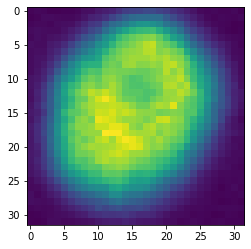

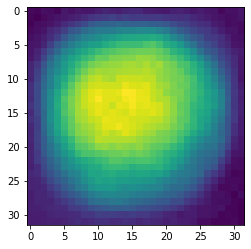

In [77]:
x = np.array([train_tracks.appearances[0][2][16]])
xhat = AE(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

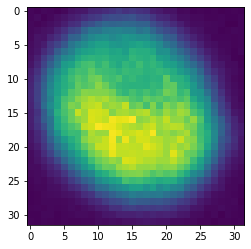

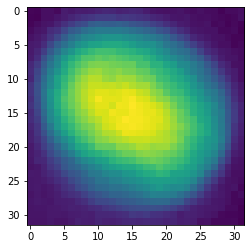

In [78]:
x = np.array([train_tracks.appearances[0][2][11]])
xhat = AE(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

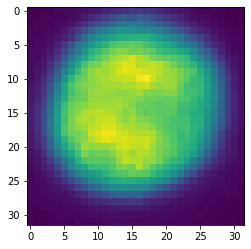

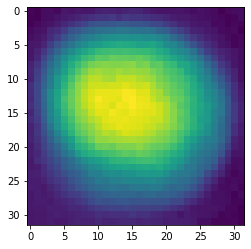

In [83]:
x = np.array([train_tracks.appearances[0][12][8]])
xhat = AE(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

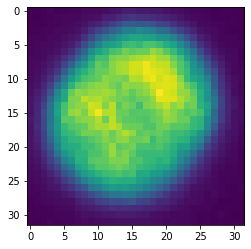

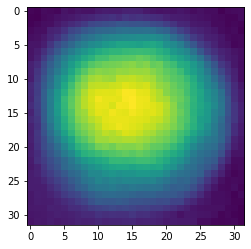

In [84]:
x = np.array([train_tracks.appearances[0][49][8]])
xhat = AE(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

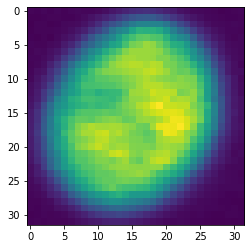

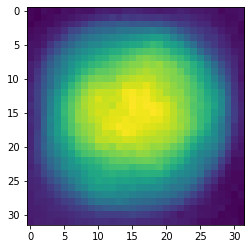

In [85]:
x = np.array([train_tracks.appearances[0][5][10]])
xhat = AE(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

In [87]:
vae_again = VAE(1024, 1, 1e-3, 64, 4, 32)
AE_again = vae_again.build_vae_keras_model()

In [88]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3838
validation_steps = 895
n_epochs = 10
model_path = '/deepcell_data/users/manav/summer_2022/models/small_img_4_layers_10_epochs'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
      
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=True)
]

loss_history = AE_again.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

Epoch 1/10
3837/3838 [============================>.] - ETA: 0s - loss: -1854.4036
Epoch 1: val_loss improved from inf to -1051.60559, saving model to /deepcell_data/users/manav/summer_2022/models/small_img_4_layers_10_epochs
3838/3838 [==============================] - 103s 26ms/step - loss: -1854.2347 - val_loss: -1051.6056 - lr: 0.0010
Epoch 2/10
3836/3838 [============================>.] - ETA: 0s - loss: -1904.3253
Epoch 2: val_loss improved from -1051.60559 to -1094.57935, saving model to /deepcell_data/users/manav/summer_2022/models/small_img_4_layers_10_epochs
3838/3838 [==============================] - 85s 22ms/step - loss: -1903.9727 - val_loss: -1094.5793 - lr: 0.0010
Epoch 3/10
3837/3838 [============================>.] - ETA: 0s - loss: -1904.2145
Epoch 3: val_loss improved from -1094.57935 to -1186.30237, saving model to /deepcell_data/users/manav/summer_2022/models/small_img_4_layers_10_epochs
3838/3838 [==============================] - 58s 15ms/step - loss: -1904.0566

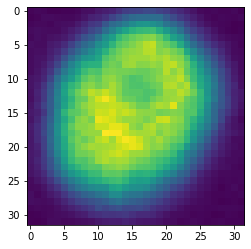

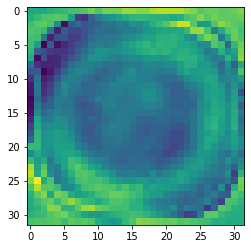

In [89]:
x = np.array([train_tracks.appearances[0][2][16]])
xhat = AE_again(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

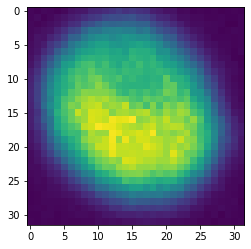

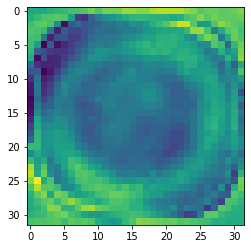

In [91]:
x = np.array([train_tracks.appearances[0][2][11]])
xhat = AE_again(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

In [92]:
vae = VAE(1024, 1, 1e-3, 64, 4, 32)
AE = vae.build_vae_keras_model()

In [93]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3838
validation_steps = 895
n_epochs = 5
model_path = '/deepcell_data/users/manav/summer_2022/models/small_img_4_layers'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
      
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=True)
]

loss_history = AE.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

Epoch 1/5
3836/3838 [============================>.] - ETA: 0s - loss: -1862.0957
Epoch 1: val_loss improved from inf to -1080.31335, saving model to /deepcell_data/users/manav/summer_2022/models/small_img_4_layers
3838/3838 [==============================] - 96s 23ms/step - loss: -1861.7406 - val_loss: -1080.3134 - lr: 0.0010
Epoch 2/5
3836/3838 [============================>.] - ETA: 0s - loss: -1905.8969
Epoch 2: val_loss did not improve from -1080.31335
3838/3838 [==============================] - 56s 15ms/step - loss: -1905.5334 - val_loss: -1031.3958 - lr: 0.0010
Epoch 3/5
3835/3838 [============================>.] - ETA: 0s - loss: -1904.0594
Epoch 3: val_loss did not improve from -1080.31335
3838/3838 [==============================] - 53s 14ms/step - loss: -1903.5381 - val_loss: -1067.1632 - lr: 0.0010
Epoch 4/5
3838/3838 [==============================] - ETA: 0s - loss: -1901.6329
Epoch 4: val_loss improved from -1080.31335 to -1253.91003, saving model to /deepcell_data/user

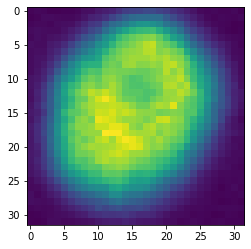

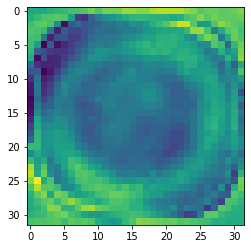

In [94]:
x = np.array([train_tracks.appearances[0][2][16]])
xhat = AE_again(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

In [82]:
train_good_imgs[0]

{0: {0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9,
  10: 10,
  11: 11,
  12: 12,
  13: 13,
  14: 14,
  15: 15,
  16: 16,
  17: 17,
  18: 18,
  19: 19,
  20: 20,
  21: 21,
  22: 22,
  23: 23,
  24: 24,
  25: 25,
  26: 26,
  27: 27,
  28: 28,
  29: 29,
  30: 30,
  31: 31,
  32: 32,
  33: 33,
  34: 34,
  35: 35,
  36: 36,
  37: 37,
  38: 38,
  39: 39,
  40: 40,
  41: 41,
  42: 42,
  43: 43,
  44: 44,
  45: 45,
  46: 46,
  47: 47,
  48: 48,
  49: 49,
  50: -1,
  51: -1,
  52: -1,
  53: -1,
  54: -1,
  55: -1,
  56: -1,
  57: -1,
  58: -1,
  59: -1,
  60: -1,
  61: -1,
  62: -1,
  63: -1,
  64: -1,
  65: -1,
  66: -1,
  67: -1,
  68: -1,
  69: -1,
  70: -1},
 1: {0: 50,
  1: 51,
  2: 52,
  3: 53,
  4: 54,
  5: 55,
  6: 56,
  7: 57,
  8: 58,
  9: 59,
  10: 60,
  11: 61,
  12: 62,
  13: 63,
  14: 64,
  15: 65,
  16: 66,
  17: 67,
  18: 68,
  19: 69,
  20: 70,
  21: 71,
  22: 72,
  23: 73,
  24: 74,
  25: 75,
  26: 76,
  27: 77,
  28: 78,
  29: 79,
  30: 80,
  3

In [39]:
vae2 = VAE(1024, 1, 1e-3, 64, 2, 32)
AE2 = vae2.build_vae_keras_model()

In [40]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3838
validation_steps = 895
n_epochs = 1
model_path = '/deepcell_data/users/manav/summer_2022/models/small_img_2_layers'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
      
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=True)
]

loss_history = AE2.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

3834/3838 [============================>.] - ETA: 0s - loss: nan
Epoch 1: val_loss did not improve from inf
3838/3838 [==============================] - 54s 14ms/step - loss: nan - val_loss: nan - lr: 0.0010


In [61]:
class VAE_MNIST:
    
    def __init__(self, dim_z, kl_weight, learning_rate):
        # change dim from (28, 28, 1)
        self.dim_x = (32, 32, 1)
        self.dim_z = dim_z
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate

    # Sequential API encoder
    def encoder_z(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfd.Independent(tfd.Normal(loc=tf.zeros(self.dim_z), scale=1.), 
                                reinterpreted_batch_ndims=1)
        # build layers argument for tfk.Sequential()
        input_shape = self.dim_x
        layers = [tfkl.InputLayer(input_shape=input_shape)]
        layers.append(tfkl.Conv2D(filters=32, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Conv2D(filters=64, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Flatten())
        # the following two lines set the output to be a probabilistic distribution
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_z), 
                                 activation=None, name='z_params'))
        layers.append(tfpl.IndependentNormal(self.dim_z, 
            convert_to_tensor_fn=tfd.Distribution.sample, 
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=self.kl_weight), 
            name='z_layer'))
        return tfk.Sequential(layers, name='encoder')
    
    # Sequential API decoder
    def decoder_x(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_z)]
        # probably 7 before since 28/2/2 = 7, so changing to 32/2/2 = 8
        layers.append(tfkl.Dense(8*8*32, activation=None))
        layers.append(tfkl.Reshape((8,8,32)))
        layers.append(tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                           padding='same'))
        layers.append(tfkl.Flatten())
        # note that here we don't need 
        # `tfkl.Dense(tfpl.IndependentBernoulli.params_size(self.dim_x))` because 
        # we've restored the desired input shape with the last Conv2DTranspose layer
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_x), 
                                 activation=None, name='x_params'))
        layers.append(tfpl.IndependentNormal(self.dim_x,
            name='x_layer'))
        return tfk.Sequential(layers, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = tfk.Input(shape=self.dim_x)
        encoder = self.encoder_z()
        decoder = self.decoder_x()
        z = encoder(x_input)

        # compile VAE model
        model = tfk.Model(inputs=x_input, outputs=decoder(z))
        model.compile(loss=negative_log_likelihood, 
                      optimizer=tfk.optimizers.Adam(self.learning_rate))
        return model

# the negative of log-likelihood for probabilistic output
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [64]:
vae3 = VAE_MNIST(1024, 1, 1e-3)
AE3 = vae3.build_vae_keras_model()

In [65]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3838
validation_steps = 895
n_epochs = 10
model_path = '/data/summer_2022/models/small_img_2_layers_normal'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
      
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=True)
]

loss_history = AE3.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

Epoch 1/10
3836/3838 [============================>.] - ETA: 0s - loss: -2915.8843
Epoch 1: val_loss improved from inf to -2978.33984, saving model to /data/summer_2022/models/small_img_2_layers_normal
3838/3838 [==============================] - 55s 14ms/step - loss: -2915.7942 - val_loss: -2978.3398 - lr: 0.0010
Epoch 2/10
3835/3838 [============================>.] - ETA: 0s - loss: -3551.4998
Epoch 2: val_loss improved from -2978.33984 to -3430.92163, saving model to /data/summer_2022/models/small_img_2_layers_normal
3838/3838 [==============================] - 51s 13ms/step - loss: -3551.1506 - val_loss: -3430.9216 - lr: 0.0010
Epoch 3/10
3837/3838 [============================>.] - ETA: 0s - loss: -3801.8682
Epoch 3: val_loss improved from -3430.92163 to -3587.87280, saving model to /data/summer_2022/models/small_img_2_layers_normal
3838/3838 [==============================] - 51s 13ms/step - loss: -3801.6904 - val_loss: -3587.8728 - lr: 0.0010
Epoch 4/10
3837/3838 [==============

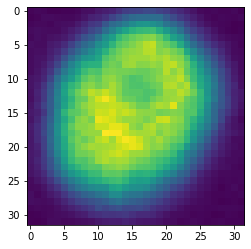

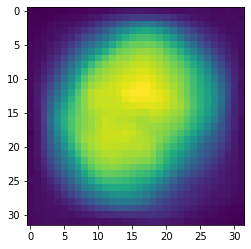

In [69]:
x = np.array([train_tracks.appearances[0][2][16]])
xhat = AE3(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

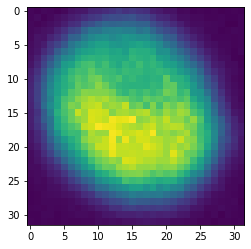

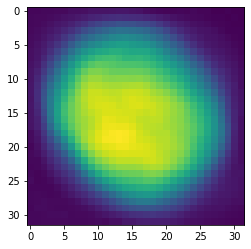

In [79]:
x = np.array([train_tracks.appearances[0][2][11]])
xhat = AE3(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

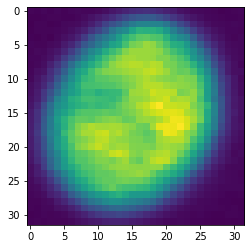

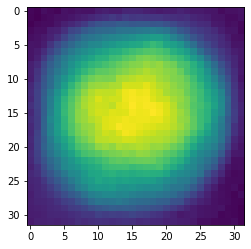

In [86]:
x = np.array([train_tracks.appearances[0][5][10]])
xhat = AE(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])